In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import json
import os
import random
import cv2

print(f"pandas version: {pd.__version__}")
print(f"numpy version: {np.__version__}")

In [ ]:
# Training dataset
train_df = pd.read_csv('/kaggle/input/imaterialist-fashion-2020-fgvc7/train.csv')
train_df.head()

In [ ]:
# Get datasets shapes
print(f'Training dataset shape: {train_df.shape}')
print(f'Unique images training: {train_df["ImageId"].nunique()}')

In [ ]:
# Get image size distribution
shape_df = train_df.groupby("ImageId")[["Height", "Width"]].first()
for dim in ["Height", "Width"]:
    plt.figure()
    plt.hist(shape_df[dim], bins=50)
    plt.grid()
    plt.title(f"{dim} distribution")

In [ ]:
# Plot randomly selected image
plt.figure(figsize=(70,7))
random_image = train_df.sample()["ImageId"].item()
plt.imshow(mpimg.imread(f'/kaggle/input/imaterialist-fashion-2020-fgvc7/train/{random_image}.jpg'))
plt.grid(False)
plt.show()

In [ ]:
# Get label file
with open('/kaggle/input/imaterialist-fashion-2020-fgvc7/label_descriptions.json', 'r') as file:
    label_d = json.load(file)

print("Label description columns {}".format(list(label_d.keys())))

In [ ]:
# Separate label description into categories and attributes
categories_df = pd.DataFrame(label_d['categories'])
attributes_df = pd.DataFrame(label_d['attributes'])

In [ ]:
categories_df

In [ ]:
# make all categories stored by one variables
categ_names = categories_df["name"].unique()
print(categ_names)
print(f"Number of attributes {len(categ_names)}")

In [ ]:
# make all attributes stored by one variables
attr_names = attributes_df["name"].unique()
print(attr_names)
print(f"Number of attributes {len(attr_names)}")

In [ ]:
# Create dictionaries to map the IDs with the category and attributes strings
cat_map = {category["id"]: category["name"] for category in label_d['categories']}
cat_map_inv = {category["name"]: category["id"] for category in label_d['categories']}

attr_map = {category["id"]: category["name"] for category in label_d['attributes']}
attr_map_inv = {category["name"]: category["id"] for category in label_d['attributes']}

In [ ]:
cat_map

# Plot segmented images

In [ ]:
def plot_raw_segmented_image(df, figsize=(15,15)):
    # Read random image
    random_id = df.sample()["ImageId"].item()
    image = mpimg.imread(f'/kaggle/input/imaterialist-fashion-2020-fgvc7/train/{random_id}.jpg')
    shape = image.shape,
    encoded_pixels = df[train_df['ImageId'] == random_id]['EncodedPixels']
    class_ids = df[train_df['ImageId'] == random_id]['ClassId']
    
    # Create mask
    height, width = shape[0][:2]
    mask = np.zeros((height, width)).reshape(-1)
    for pixels, class_id in zip(encoded_pixels, class_ids):
        pixels_split = list(map(int, pixels.split()))
        pixel_starts = pixels_split[::2]
        run_lengths = pixels_split[1::2]
        for pixel_start, run_length in zip(pixel_starts, run_lengths):
            mask[pixel_start:pixel_start + run_length] = 255 - int(class_id) * 4
    mask = mask.reshape(height, width, order='F')    
    
    # Plot images
    fig, axs = plt.subplots(1, 2,figsize=(15,15))
    axs[0].imshow(image)    
    axs[1].imshow(image)    
    axs[1].imshow(mask, alpha=0.8)
    plt.show()

In [ ]:
# Plot raw and segmented images
size = 3
for _ in range(size):
    plot_raw_segmented_image(train_df, "ImageId")

In [ ]:
def plot_classes_image(df, figsize=(15,15)):
    # Select random image
    random_id = df.sample()["ImageId"].item()
    image = mpimg.imread(f'/kaggle/input/imaterialist-fashion-2020-fgvc7/train/{random_id}.jpg')
    shape = image.shape,
    encoded_pixels = df[train_df['ImageId'] == random_id]['EncodedPixels']
    class_ids = df[train_df['ImageId'] == random_id]['ClassId']
    
    # Create mask and plot every specific class in the image
    height, width = shape[0][:2]
    for pixels, class_id in zip(encoded_pixels, class_ids):
        mask = np.zeros((height, width)).reshape(-1)
        pixels_split = list(map(int, pixels.split()))
        pixel_starts = pixels_split[::2]
        run_lengths = pixels_split[1::2]
        for pixel_start, run_length in zip(pixel_starts, run_lengths):
            mask[pixel_start:pixel_start + run_length] = 255 - int(class_id) * 4
        mask = mask.reshape(height, width, order='F')
        
        # Plot masked image
        plt.figure(figsize=(15, 15))
        title_raw = cat_map[int(class_id)]
        plt.title(title_raw)
        plt.imshow(image)    
        plt.imshow(mask, alpha=0.8)
        plt.show()

In [ ]:
plot_classes_image(train_df)

# Detectron

In [ ]:
!pip install -q cython pyyaml

In [ ]:
!pip install pycocotools==2.0.2

In [ ]:
!pip install 'git+https://github.com/facebookresearch/detectron2.git'

## Make libraries

In [ ]:
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog
from detectron2.structures import BoxMode

## Use detectron in current dataset

In [ ]:
!pip install torch

In [ ]:
import torch
torch.cuda.is_available()

In [ ]:
!python -m torch.utils.collect_env

In [ ]:
# Use detectron to predict images in the current dataset,
# use the default weights and labels from the network
config_file = "COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file(config_file))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url(config_file)

predictor = DefaultPredictor(cfg)

In [ ]:
# Plot images classified by the pretrained detectron
rows, cols = 2, 2
plt.figure(figsize=(20, 20))

for i in range(int(rows * cols)):
    plt.subplot(rows, cols, i + 1)
    
    # Get random image
    random_id = train_df.sample()["ImageId"].item()
    im = mpimg.imread(f'/kaggle/input/imaterialist-fashion-2020-fgvc7/train/{random_id}.jpg')
    height, width = im.shape[:2]
    
    # Get detectron prediction from the selected image
    outputs = predictor(im)
    
    # Create visualizer
    visualizer = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=0.4)
    
    # Change font size for better reading
    visualizer._default_font_size = np.sqrt(height * width) // 20
    visualizer = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    
    # Plot images
    plt.axis('off')
    plt.imshow(visualizer.get_image()[:, :, ::-1])

plt.show()

# Add Details

In [ ]:
def rle_decode_string(string, h, w):
    """
    Transforms rle string into a pixel mask
    
    :param string: rle string to transform into mask
    :type string: str
    :param string: image height
    :type string: int
    :param string: image width
    :type string: int
    :return: image mask
    :rtype: numpy array

    """
    mask = np.full(h * w, 0, dtype=np.uint8)
    annotation = [int(x) for x in string.split(' ')]
    for i, start_pixel in enumerate(annotation[::2]):
        mask[start_pixel: start_pixel + annotation[2 * i + 1]] = 1
    mask = mask.reshape((h, w), order='F')
    return mask

def rle2bbox(rle, shape):
    '''
    Get a bbox from a mask which is required for Detectron 2 dataset
    :param rle: run-length encoded image mask, as string
    :type rle: str
    :param shape: (height, width) of image on which RLE was produced
    :type rle: tuple
    :return: (x0, y0, x1, y1) tuple describing the bounding box of the rle mask
    :rtype: tuple
    '''
    
    a = np.fromiter(rle.split(), dtype=np.uint)
    a = a.reshape((-1, 2))  # an array of (start, length) pairs
    a[:,0] -= 1  # `start` is 1-indexed
    
    y0 = a[:,0] % shape[0]
    y1 = y0 + a[:,1]
    if np.any(y1 > shape[0]):
        # got `y` overrun, meaning that there are a pixels in mask on 0 and shape[0] position
        y0 = 0
        y1 = shape[0]
    else:
        y0 = np.min(y0)
        y1 = np.max(y1)
    
    x0 = a[:,0] // shape[0]
    x1 = (a[:,0] + a[:,1]) // shape[0]
    x0 = np.min(x0)
    x1 = np.max(x1)
    
    if x1 > shape[1]:
        # just went out of the image dimensions
        raise ValueError("invalid RLE or image dimensions: x1=%d > shape[1]=%d" % (
            x1, shape[1]
        ))

    return x0, y0, x1, y1

In [ ]:
# Transform ImageId into image path
image_dir = '/kaggle/input/imaterialist-fashion-2020-fgvc7/train/'
train_df['ImageId'] = image_dir + train_df['ImageId'] + '.jpg'
train_df.head()

In [ ]:
train_df['ImageId'][40]

In [ ]:
# Create boxes list
bboxes = [rle2bbox(c.EncodedPixels, (c.Height, c.Width)) for n, c in train_df.iterrows()]
bboxes_array = np.array(bboxes)

In [ ]:
# Fill NaNs
train_df = train_df.fillna(999)

In [ ]:
# Add bounding boxes coordinates to train using detectron
train_df['x0'], train_df['y0'], train_df['x1'], train_df['y1'] = bboxes_array[:,0], bboxes_array[:,1], bboxes_array[:,2], bboxes_array[:,3]
train_df.head()

In [ ]:
def transform_to_array(value):
    if isinstance(value, (np.ndarray, np.generic)):
        return value
    elif isinstance(value, str):
        array = [int(val) for val in value.split(",")]
    elif isinstance(value, int):
        array = [999] 
    array = np.array(array)
    return np.pad(array, (0, 14 - len(array)))

In [ ]:
# Transform attribute string into tensor
train_df["AttributesIds"] = train_df["AttributesIds"].map(transform_to_array)
train_df.head()

In [ ]:
train_df['ImageId'][100]

In [ ]:
# Store modified train_df
train_df.to_pickle("train_df.pickle")

In [ ]:
print(len(train_df))

# Get data to train

In [ ]:
import pycocotools
def get_materialist_dicts(df):
    """
    Transforms dataframe into dictionary used to train using detectron
    """
    dataset_dicts = []
    for idx, filename in enumerate(df["ImageId"].unique()):
        record = {}
        # Get useful image information
        height, width = df[df["ImageId"] == filename][["Height", "Width"]].values[0]
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = int(height)
        record["width"] = int(width)
        
        if idx % 1000 == 0:
            print(idx)
        
        objs = []
        for i, row in df[(df['ImageId'] == filename)].iterrows():
            
            # Get segmentation polygons
            mask = rle_decode_string(row['EncodedPixels'], row['Height'], row['Width'])
            # segmentation = pycocotools.mask.encode(np.asarray(mask, order="F"))
            contours, hierarchy = cv2.findContours((mask).astype(np.uint8), cv2.RETR_TREE,
                                                    cv2.CHAIN_APPROX_SIMPLE)
            segmentation = []

            for contour in contours:
                contour = contour.flatten().tolist()
                if len(contour) > 4:
                    segmentation.append(contour)

            obj = {
                "bbox": [row['x0'], row['y0'], row['x1'], row['y1']],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": segmentation,
                "category_id": row['ClassId'],
                "attributes": row['AttributesIds'],
                "iscrowd": 0,
            }
            objs.append(obj)
        
        record['annotations'] = objs
        dataset_dicts.append(record)
    return dataset_dicts

# Use reduced dictionary to reduce the time to transform into dictionaries
#df_copy = train_df[:8000].copy()

df_copy = train_df.copy()

df_copy = train_df[:23000].copy()
df_copy_val = train_df[23000:24000].copy()

# Full dictionary
# df_copy = train_df.copy()

materialist_dict = get_materialist_dicts(df_copy)

In [ ]:
materialist_dict[0].keys()

In [ ]:
print(len(df_copy))
print(len(df_copy_val))
print(len(materialist_dict))
print(len(train_df))
print(len(train_df["ImageId"].unique()))
print(len(df_copy["ImageId"].unique()))

In [ ]:
# Register the custom dataset to detectron2,
for d in ["train", "val"]:
    if d == "train":
        used_df = df_copy
    else:
        used_df = df_copy_val
    DatasetCatalog.register("mat_" + d, lambda df=used_df: get_materialist_dicts(df))
    # DatasetCatalog.register("mat_" + d, lambda df=df_copy: get_materialist_dicts(df))
    MetadataCatalog.get("mat_" + d).set(thing_classes=list(categories_df.name))
materialist_metadata = MetadataCatalog.get("mat_train")

In [ ]:
# To verify the data loading is correct we visualize the annotations of randomly selected samples in the training set
for d in random.sample(materialist_dict, 5):
    img = cv2.imread(d["file_name"])
    img = mpimg.imread(d["file_name"])
    height, width = img.shape[:2]
    plt.figure(figsize=(20, 20))
    visualizer = Visualizer(img[:, :, ::-1], metadata=materialist_metadata, scale=0.5)
    visualizer._default_font_size = np.sqrt(height * width) // 20
    out = visualizer.draw_dataset_dict(d)
    plt.imshow(out.get_image()[:, :, ::-1])
    plt.axis('off')
    plt.show()

# Prepare to train

In [ ]:
logdir = "logs" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tensorflow.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
# load extension tensorboard
%load_ext tensorboard
%tensorboard  --logdir output

In [ ]:
%tensorboard  --logdir=(logdir)

# FPN

In [ ]:
from detectron2.utils.logger import setup_logger
setup_logger()

In [ ]:
from detectron2.engine import DefaultTrainer
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Fine-tune a COCO-pretrained R50-FPN Mask R-CNN model on the dataset
cfg_FPN = get_cfg()
cfg_FPN.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg_FPN.DATASETS.TRAIN = ("mat_train",)
cfg_FPN.DATASETS.TEST = ("mat_val",)
cfg_FPN.DATALOADER.NUM_WORKERS = 1
cfg_FPN.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg_FPN.SOLVER.IMS_PER_BATCH = 2
cfg_FPN.SOLVER.BASE_LR = 0.00025 
cfg_FPN.SOLVER.MAX_ITER = 1000  
cfg_FPN.SOLVER.STEPS = []       
cfg_FPN.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  
cfg_FPN.MODEL.ROI_HEADS.NUM_CLASSES = 46 

# Train
cfg_FPN.OUTPUT_DIR = "./output_FPN"
os.makedirs(cfg_FPN.OUTPUT_DIR, exist_ok=True)
trainer_FPN = DefaultTrainer(cfg_FPN) 
trainer_FPN.resume_or_load(resume=False)
trainer_FPN.train()

In [ ]:
# Create predictor from the weigths obtained during the training
cfg_FPN.MODEL.WEIGHTS = os.path.join(cfg_FPN.OUTPUT_DIR, "model_final.pth")
cfg_FPN.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg_FPN.DATASETS.TEST = ('mat_val',)
predictor_FPN = DefaultPredictor(cfg_FPN)

In [42]:
%reload_ext tensorboard

%tensorboard --logdir output --bind_all

In [ ]:
from detectron2.utils.visualizer import ColorMode
plt.figure(figsize=(20,20))
for d in random.sample(materialist_dict, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor_FPN(im)
    visualizer = Visualizer(im[:, :, ::-1],
                   metadata=materialist_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image()[:, :, ::-1])

In [ ]:
from detectron2.utils.visualizer import ColorMode

# Show different images at random
rows, cols = 3, 3
plt.figure(figsize=(20,20))

for i, d in enumerate(random.sample(materialist_dict, 9)):
    # Process image
    plt.subplot(rows, cols, i+1)

    im = cv2.imread(d["file_name"])
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    
    # Run through predictor
    outputs = predictor_FPN(im)
    
    # Visualize
    v = Visualizer(im[:, :, ::-1],
                   metadata=materialist_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image()[:, :, ::-1])

plt.show()

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Evaluate model
evaluator_FPN = COCOEvaluator("mat_val", output_dir="./output")
val_loader_FPN = build_detection_test_loader(cfg_FPN, "mat_val")

In [ ]:
# Get results
result_FPN = inference_on_dataset(predictor_FPN.model, val_loader_FPN, evaluator_FPN)

In [ ]:
result_FPN

In [ ]:
result_FPN = OrderedDict([('bbox',
              {'AP': 4.042041386236529,
               'AP50': 7.009528515579133,
               'AP75': 4.272181159399969,
               'APs': 2.8642149929278644,
               'APm': 4.436359715472674,
               'APl': 4.175886251256949,
               'AP-shirt, blouse': 0.0,
               'AP-top, t-shirt, sweatshirt': 3.6115040075436116,
               'AP-sweater': 0.0,
               'AP-cardigan': 0.0,
               'AP-jacket': 0.0,
               'AP-vest': 0.0,
               'AP-pants': 22.712319374254037,
               'AP-shorts': 0.0,
               'AP-skirt': 0.0,
               'AP-coat': 0.0,
               'AP-dress': 36.79138174864801,
               'AP-jumpsuit': 0.0,
               'AP-cape': 0.0,
               'AP-glasses': 0.0,
               'AP-hat': 0.0,
               'AP-headband, head covering, hair accessory': 0.0,
               'AP-tie': 0.0,
               'AP-glove': 0.0,
               'AP-watch': 0.0,
               'AP-belt': 0.0,
               'AP-leg warmer': -1,
               'AP-tights, stockings': 0.0,
               'AP-sock': 0.0,
               'AP-shoe': 42.691991932292986,
               'AP-bag, wallet': 0.0,
               'AP-scarf': 0.0,
               'AP-umbrella': -1,
               'AP-hood': 0.0,
               'AP-collar': 8.310573351834575,
               'AP-lapel': 0.0,
               'AP-epaulette': 0.0,
               'AP-sleeve': 36.739201247615455,
               'AP-pocket': 0.0,
               'AP-neckline': 6.782642401035951,
               'AP-buckle': 0.0,
               'AP-zipper': 0.0,
               'AP-applique': 0.0,
               'AP-bead': 0.0,
               'AP-bow': 0.0,
               'AP-flower': -1,
               'AP-fringe': -1,
               'AP-ribbon': -1,
               'AP-rivet': 0.0,
               'AP-ruffle': 0.0,
               'AP-sequin': -1,
               'AP-tassel': -1}),
             ('segm',
              {'AP': 3.4087200430046565,
               'AP50': 5.657970853825233,
               'AP75': 3.6954433313462216,
               'APs': 0.3951495149514952,
               'APm': 2.1513857128643084,
               'APl': 3.9158018526800653,
               'AP-shirt, blouse': 0.0,
               'AP-top, t-shirt, sweatshirt': 4.867986798679868,
               'AP-sweater': 0.0,
               'AP-cardigan': 0.0,
               'AP-jacket': 0.0,
               'AP-vest': 0.0,
               'AP-pants': 29.593245025414213,
               'AP-shorts': 0.0,
               'AP-skirt': 0.0,
               'AP-coat': 0.0,
               'AP-dress': 39.42114295317396,
               'AP-jumpsuit': 0.0,
               'AP-cape': 0.0,
               'AP-glasses': 0.0,
               'AP-hat': 0.0,
               'AP-headband, head covering, hair accessory': 0.0,
               'AP-tie': 0.0,
               'AP-glove': 0.0,
               'AP-watch': 0.0,
               'AP-belt': 0.0,
               'AP-leg warmer': -1,
               'AP-tights, stockings': 0.0,
               'AP-sock': 0.0,
               'AP-shoe': 21.30350902783804,
               'AP-bag, wallet': 0.0,
               'AP-scarf': 0.0,
               'AP-umbrella': -1,
               'AP-hood': 0.0,
               'AP-collar': 0.19393233440991156,
               'AP-lapel': 0.0,
               'AP-epaulette': 0.0,
               'AP-sleeve': 37.558015312643114,
               'AP-pocket': 0.0,
               'AP-neckline': 0.0022502250225022503,
               'AP-buckle': 0.0,
               'AP-zipper': 0.0,
               'AP-applique': 0.0,
               'AP-bead': 0.0,
               'AP-bow': 0.0,
               'AP-flower': -1,
               'AP-fringe': -1,
               'AP-ribbon': -1,
               'AP-rivet': 0.0,
               'AP-ruffle': 0.0,
               'AP-sequin': -1,
               'AP-tassel': -1})])

# DC5

In [ ]:
from detectron2.engine import DefaultTrainer
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

# Fine-tune a COCO-pretrained R50-DC5 Mask R-CNN model on the dataset
cfg_DC5 = get_cfg()
cfg_DC5.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_DC5_3x.yaml"))
cfg_DC5.DATASETS.TRAIN = ("mat_train",)
cfg_DC5.DATASETS.TEST = ()
cfg_DC5.DATALOADER.NUM_WORKERS = 1
cfg_DC5.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_DC5_3x.yaml")
cfg_DC5.SOLVER.IMS_PER_BATCH = 2
cfg_DC5.SOLVER.BASE_LR = 0.00025  
cfg_DC5.SOLVER.MAX_ITER = 1000
cfg_DC5.SOLVER.STEPS = []    
cfg_DC5.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128  
cfg_DC5.MODEL.ROI_HEADS.NUM_CLASSES = 46  

# Train
cfg_DC5.OUTPUT_DIR = "./output_DC5"
os.makedirs(cfg_DC5.OUTPUT_DIR, exist_ok=True)
trainer_DC5 = DefaultTrainer(cfg_DC5) 
trainer_DC5.resume_or_load(resume=False)
trainer_DC5.train()

In [ ]:
cfg_DC5.MODEL.WEIGHTS = os.path.join(cfg_DC5.OUTPUT_DIR, "model_final.pth")
cfg_DC5.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5   # set the testing threshold for this model
cfg_DC5.DATASETS.TEST = ('mat_val')
predictor_DC5 = DefaultPredictor(cfg_DC5)

In [ ]:
# load extension tensorboard
%load_ext tensorboard
%tensorboard  --logdir output

In [ ]:
from detectron2.utils.visualizer import ColorMode
plt.figure(figsize=(20,20))
for d in random.sample(materialist_dict, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor_DC5(im)
    visualizer = Visualizer(im[:, :, ::-1],
                   metadata=materialist_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image()[:, :, ::-1])

In [ ]:
# Show different images at random
rows, cols = 3, 3
plt.figure(figsize=(20,20))
for i, d in enumerate(random.sample(materialist_dict, 9)):
    # Process image
    plt.subplot(rows, cols, i+1)
    im = cv2.imread(d["file_name"])
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    
    # Run through predictor
    outputs = predictor_DC5(im)
    
    # Visualize
    v = Visualizer(im[:, :, ::-1],
                   metadata=materialist_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image()[:, :, ::-1])
plt.show()

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Evaluate model
evaluator_DC5 = COCOEvaluator("mat_val", output_dir=cfg_DC5.OUTPUT_DIR)
val_loader_DC5 = build_detection_test_loader(cfg_DC5, "mat_val")
result_DC5 = inference_on_dataset(predictor_DC5.model, val_loader_DC5, evaluator_DC5)

In [ ]:
result_DC5

In [ ]:
import collections 
result_DC5 = collections.OrderedDict([('bbox',
              {'AP': 4.525191941379816,
               'AP50': 7.861780384443219,
               'AP75': 4.962870113473836,
               'APs': 2.690041468669624,
               'APm': 4.381724195462682,
               'APl': 4.9131784577118465,
               'AP-shirt, blouse': 0.0,
               'AP-top, t-shirt, sweatshirt': 9.08129251254038,
               'AP-sweater': 0.0,
               'AP-cardigan': 0.0,
               'AP-jacket': 0.0,
               'AP-vest': 0.0,
               'AP-pants': 28.77881395602568,
               'AP-shorts': 0.0,
               'AP-skirt': 0.0,
               'AP-coat': 0.0,
               'AP-dress': 36.62626955070075,
               'AP-jumpsuit': 0.0,
               'AP-cape': 0.0,
               'AP-glasses': 0.0,
               'AP-hat': 0.0,
               'AP-headband, head covering, hair accessory': 0.0,
               'AP-tie': 0.0,
               'AP-glove': 0.0,
               'AP-watch': 0.0,
               'AP-belt': 0.0,
               'AP-leg warmer': -1,
               'AP-tights, stockings': 0.0,
               'AP-sock': 0.0,
               'AP-shoe': 44.286675073755184,
               'AP-bag, wallet': 5.346534653465347,
               'AP-scarf': 0.0,
               'AP-umbrella': -1,
               'AP-hood': 0.0,
               'AP-collar': 0.39603960396039606,
               'AP-lapel': 0.0,
               'AP-epaulette': 0.0,
               'AP-sleeve': 43.18201285462164,
               'AP-pocket': 0.0,
               'AP-neckline': 8.784847508743479,
               'AP-buckle': 0.0,
               'AP-zipper': 0.0,
               'AP-applique': 0.0,
               'AP-bead': 0.0,
               'AP-bow': 0.0,
               'AP-flower': -1,
               'AP-fringe': -1,
               'AP-ribbon': -1,
               'AP-rivet': 0.0,
               'AP-ruffle': 0.0,
               'AP-sequin': -1,
               'AP-tassel': -1}),
             ('segm',
              {'AP': 4.148658488100851,
               'AP50': 6.764338958984722,
               'AP75': 4.433934143648775,
               'APs': 0.3431447100754031,
               'APm': 2.57813452468239,
               'APl': 4.882275533962463,
               'AP-shirt, blouse': 0.0,
               'AP-top, t-shirt, sweatshirt': 11.4868204327064,
               'AP-sweater': 0.0,
               'AP-cardigan': 0.0,
               'AP-jacket': 0.0,
               'AP-vest': 0.0,
               'AP-pants': 31.72714711007093,
               'AP-shorts': 0.0,
               'AP-skirt': 0.0,
               'AP-coat': 0.0,
               'AP-dress': 46.916030506073156,
               'AP-jumpsuit': 0.0,
               'AP-cape': 0.0,
               'AP-glasses': 0.0,
               'AP-hat': 0.0,
               'AP-headband, head covering, hair accessory': 0.0,
               'AP-tie': 0.0,
               'AP-glove': 0.0,
               'AP-watch': 0.0,
               'AP-belt': 0.0,
               'AP-leg warmer': -1,
               'AP-tights, stockings': 0.0,
               'AP-sock': 0.0,
               'AP-shoe': 23.737265884581422,
               'AP-bag, wallet': 4.158415841584159,
               'AP-scarf': 0.0,
               'AP-umbrella': -1,
               'AP-hood': 0.0,
               'AP-collar': 0.132013201320132,
               'AP-lapel': 0.0,
               'AP-epaulette': 0.0,
               'AP-sleeve': 43.63807009106468,
               'AP-pocket': 0.0,
               'AP-neckline': 0.0019179685323128938,
               'AP-buckle': 0.0,
               'AP-zipper': 0.0,
               'AP-applique': 0.0,
               'AP-bead': 0.0,
               'AP-bow': 0.0,
               'AP-flower': -1,
               'AP-fringe': -1,
               'AP-ribbon': -1,
               'AP-rivet': -1,
               'AP-ruffle': 0.0,
               'AP-sequin': -1,
               'AP-tassel': -1})])

# C4

In [ ]:
from detectron2.engine import DefaultTrainer

# Fine-tune a COCO-pretrained R50-C4 Mask R-CNN model on the dataset
cfg_C4 = get_cfg()
cfg_C4.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_3x.yaml"))
cfg_C4.DATASETS.TRAIN = ("mat_train",)
cfg_C4.DATASETS.TEST = ()
cfg_C4.DATALOADER.NUM_WORKERS = 2
cfg_C4.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_C4_3x.yaml")
cfg_C4.SOLVER.IMS_PER_BATCH = 2
cfg_C4.SOLVER.BASE_LR = 0.00025
cfg_C4.SOLVER.MAX_ITER = 1000
cfg_C4.SOLVER.STEPS = []
cfg_C4.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 128
cfg_C4.MODEL.ROI_HEADS.NUM_CLASSES = 46

# Train
cfg_C4.OUTPUT_DIR = "./output_C4"
os.makedirs(cfg_C4.OUTPUT_DIR, exist_ok=True)
trainer_C4 = DefaultTrainer(cfg_C4) 
trainer_C4.resume_or_load(resume=False)
trainer_C4.train()

In [ ]:
# Create predictor from the weigths obtained during the training
cfg_C4.MODEL.WEIGHTS = os.path.join(cfg_C4.OUTPUT_DIR, "model_final.pth")
cfg_C4.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg_C4.DATASETS.TEST = ('mat_val')
predictor_C4 = DefaultPredictor(cfg_C4)

In [ ]:
from detectron2.utils.visualizer import ColorMode
plt.figure(figsize=(20,20))
for d in random.sample(materialist_dict, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor_C4(im)
    visualizer = Visualizer(im[:, :, ::-1],
                   metadata=materialist_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = visualizer.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image()[:, :, ::-1])

In [ ]:
# Show different images at random
rows, cols = 3, 3
plt.figure(figsize=(20,20))
for i, d in enumerate(random.sample(materialist_dict, 9)):
    # Process image
    plt.subplot(rows, cols, i+1)
    im = cv2.imread(d["file_name"])
    im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)
    
    # Run through predictor
    outputs = predictor_C4(im)
    
    # Visualize
    v = Visualizer(im[:, :, ::-1],
                   metadata=materialist_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.imshow(v.get_image()[:, :, ::-1])
plt.show()

In [ ]:
from detectron2.evaluation import COCOEvaluator, inference_on_dataset
from detectron2.data import build_detection_test_loader

# Evaluate model
evaluator_C4 = COCOEvaluator("mat_val", output_dir="./output")
val_loader_C4 = build_detection_test_loader(cfg_C4, "mat_val")
result_C4 = inference_on_dataset(predictor_C4.model, val_loader_C4, evaluator_C4)

In [ ]:
result_C4

In [ ]:
result_C4 = collections.OrderedDict([('bbox',
              {'AP': 4.467343707791655,
               'AP50': 8.741681144504621,
               'AP75': 4.467835182009489,
               'APs': 2.4755099795693853,
               'APm': 3.8200423974295807,
               'APl': 5.0936944011820575,
               'AP-shirt, blouse': 0.0,
               'AP-top, t-shirt, sweatshirt': 9.964190649549916,
               'AP-sweater': 0.0,
               'AP-cardigan': 0.0,
               'AP-jacket': 0.0,
               'AP-vest': 0.0,
               'AP-pants': 28.897438521569303,
               'AP-shorts': 0.0,
               'AP-skirt': 6.9306930693069315,
               'AP-coat': 0.0,
               'AP-dress': 33.31648666484868,
               'AP-jumpsuit': 0.0,
               'AP-cape': 0.0,
               'AP-glasses': 0.0,
               'AP-hat': 0.0,
               'AP-headband, head covering, hair accessory': 0.0,
               'AP-tie': 0.0,
               'AP-glove': 0.0,
               'AP-watch': 0.0,
               'AP-belt': 0.0,
               'AP-leg warmer': -1,
               'AP-tights, stockings': 0.0,
               'AP-sock': 0.0,
               'AP-shoe': 30.470569136050194,
               'AP-bag, wallet': 4.752475247524752,
               'AP-scarf': 0.0,
               'AP-umbrella': -1,
               'AP-hood': 0.0,
               'AP-collar': 0.0,
               'AP-lapel': 6.188904604746188,
               'AP-epaulette': 0.0,
               'AP-sleeve': 41.37866770291117,
               'AP-pocket': 0.0,
               'AP-neckline': 12.32697900736742,
               'AP-buckle': 0.0,
               'AP-zipper': 0.0,
               'AP-applique': 0.0,
               'AP-bead': 0.0,
               'AP-bow': 0.0,
               'AP-flower': -1,
               'AP-fringe': -1,
               'AP-ribbon': -1,
               'AP-rivet': 0.0,
               'AP-ruffle': 0.0,
               'AP-sequin': -1,
               'AP-tassel': -1}),
             ('segm',
              {'AP': 3.944894844933721,
               'AP50': 6.668759092165412,
               'AP75': 4.179548972045359,
               'APs': 0.25586189388169583,
               'APm': 1.9828757378409902,
               'APl': 4.711149322337242,
               'AP-shirt, blouse': 0.0,
               'AP-top, t-shirt, sweatshirt': 13.345997577369797,
               'AP-sweater': 0.0,
               'AP-cardigan': 0.0,
               'AP-jacket': 0.0,
               'AP-vest': 0.0,
               'AP-pants': 31.943161622461858,
               'AP-shorts': 0.0,
               'AP-skirt': 8.91089108910891,
               'AP-coat': 0.0,
               'AP-dress': 36.07056174690547,
               'AP-jumpsuit': 0.0,
               'AP-cape': 0.0,
               'AP-glasses': 0.0,
               'AP-hat': 0.0,
               'AP-headband, head covering, hair accessory': 0.0,
               'AP-tie': 0.0,
               'AP-glove': 0.0,
               'AP-watch': 0.0,
               'AP-belt': 0.0,
               'AP-leg warmer': -1,
               'AP-tights, stockings': 0.0,
               'AP-sock': 0.0,
               'AP-shoe': 15.510367816578915,
               'AP-bag, wallet': 4.158415841584159,
               'AP-scarf': 0.0,
               'AP-umbrella': -1,
               'AP-hood': 0.0,
               'AP-collar': 0.0,
               'AP-lapel': 0.0,
               'AP-epaulette': 0.0,
               'AP-sleeve': 43.88888280120257,
               'AP-pocket': 0.0,
               'AP-neckline': 0.022620457203460627,
               'AP-buckle': 0.0,
               'AP-zipper': 0.0,
               'AP-applique': 0.0,
               'AP-bead': 0.0,
               'AP-bow': 0.0,
               'AP-flower': -1,
               'AP-fringe': -1,
               'AP-ribbon': -1,
               'AP-rivet': 0.0,
               'AP-ruffle': 0.0,
               'AP-sequin': -1,
               'AP-tassel': -1})])

# Evaluation

In [ ]:
results_dict = {}

# Create table to compare results
results_dict['bbox_DC5'] = result_DC5['bbox']
results_dict['bbox_C4'] = result_C4['bbox']
#results_dict['bbox_FPN'] = result_FPN['bbox']
results_dict['segm_DC5'] = result_DC5['segm']
results_dict['segm_C4'] = result_C4['segm']
#results_dict['segm_FPN'] = result_FPN['segm']

df_results = pd.DataFrame.from_dict(results_dict)
df_results.loc[['AP', 'AP50', 'AP75', 'APs', 'APm', 'APl']]

In [ ]:
import ast

metrics = {}

# Create losses plots
#for folder in ["FPN", "C4", "DC5"]:
for folder in ["C4", "DC5"]:
    with open(f'output_{folder}/metrics.json') as file:
        lines = file.readlines()
    
    metrics_model = []
    for line in lines:
        metrics_model.append(ast.literal_eval(line))
    metrics[folder] = metrics_model

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(3, 4, figsize=(20,10))

#for idx, model in enumerate(["FPN", "C4", "DC5"]):
for idx, model in enumerate(["C4", "DC5"]):
    met = metrics[model]
    for loss_id, loss in enumerate(["loss_box_reg", "loss_mask", "loss_cls", "total_loss"]):
        ax = axs[idx, loss_id]
        total_loss = [loss_dict[loss] for loss_dict in met]
        iterations = [loss_dict['iteration'] for loss_dict in met]

        ax.set_title(f"{model} - {loss}")
        ax.set_xlabel("iterations")
        ax.plot(iterations, total_loss)
        ax.grid()
        
fig.tight_layout()

In [ ]:
import os
os.chdir(r'/kaggle/working/output_C4')

from IPython.display import FileLink

FileLink(r'metrics.json')

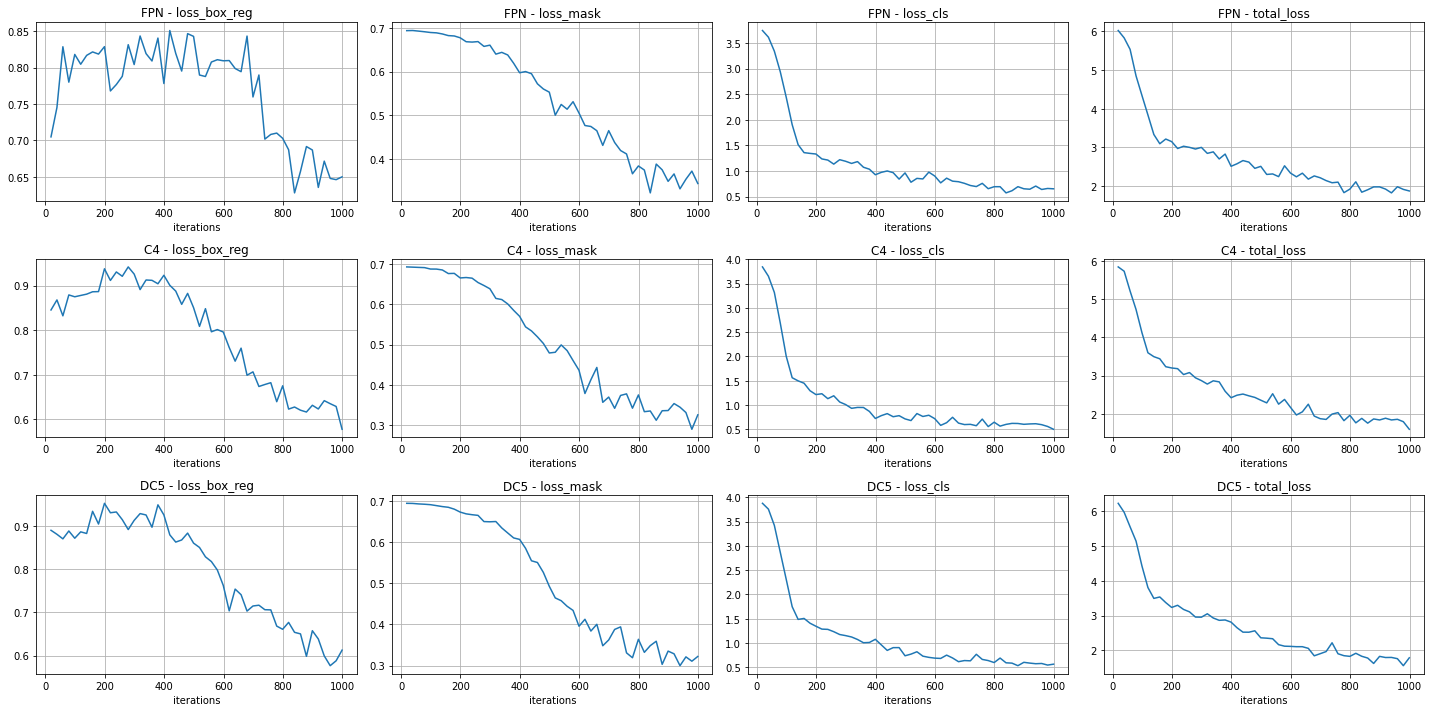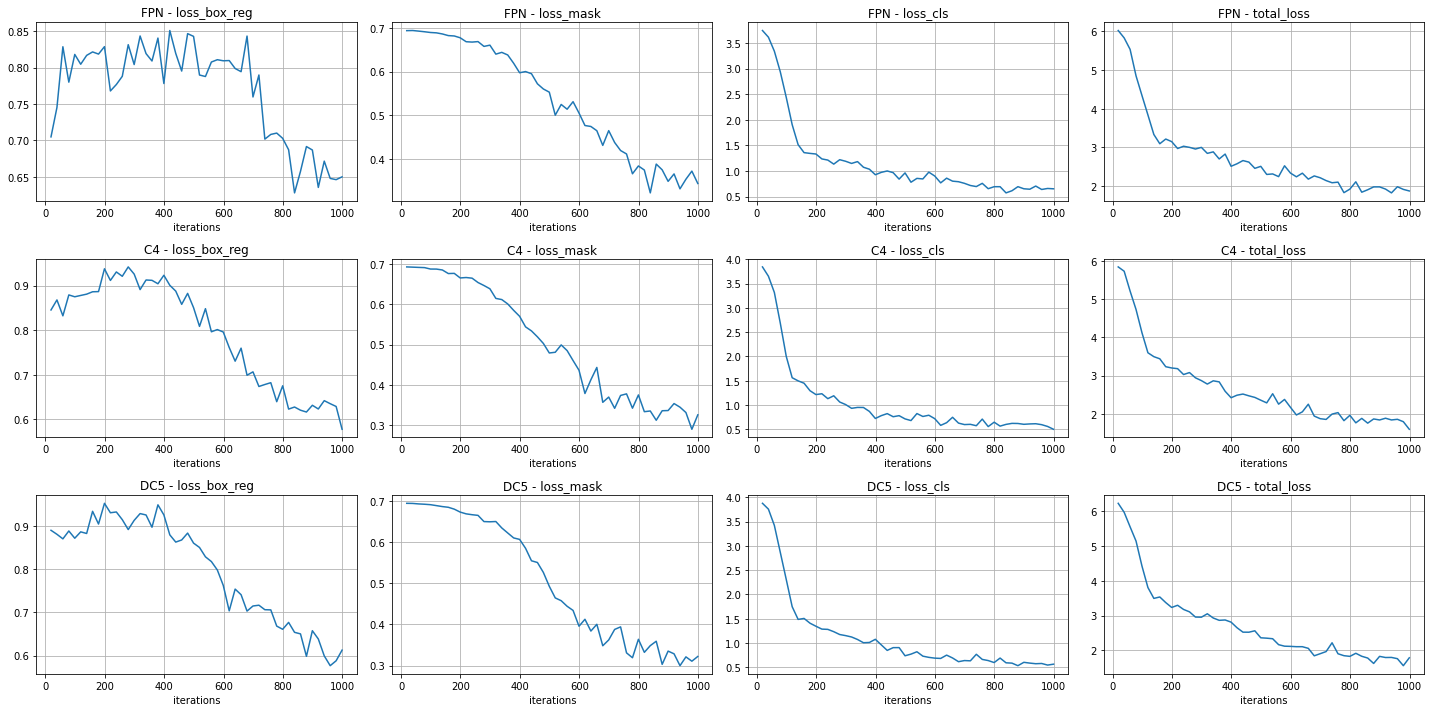